This notebook analyses our results for the success probability and median running time of QAOA for $k$-SAT.

The result data for this experiment can all be found in `experiments/`.

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
parent_dir = os.path.dirname(os.getcwd())

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py

In [4]:
# Parameters
ps = [1, 2, 4, 8, 16]
ks = [4, 8]
ns = [i for i in range(12, 21)]
num_proc = 10
batch_size = 250

First we analyse the success probability

In [5]:
# Extract
dir = f'{parent_dir}/experiments/ksat_eval/ksat_p_succ'
psuccs = {k : {n : {p : 0 for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/k_{k}/p_succ_{n}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

<Figure size 1500x1000 with 0 Axes>

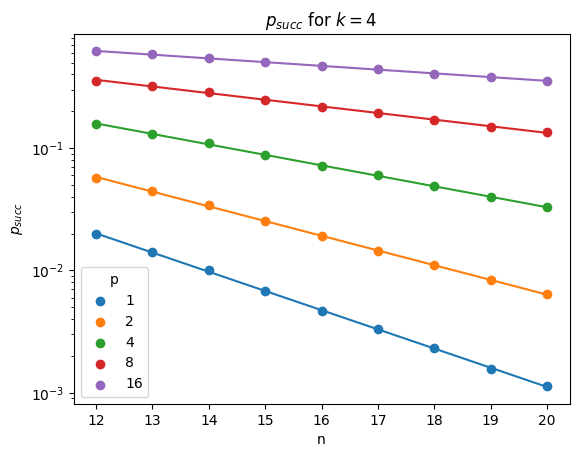

<Figure size 1500x1000 with 0 Axes>

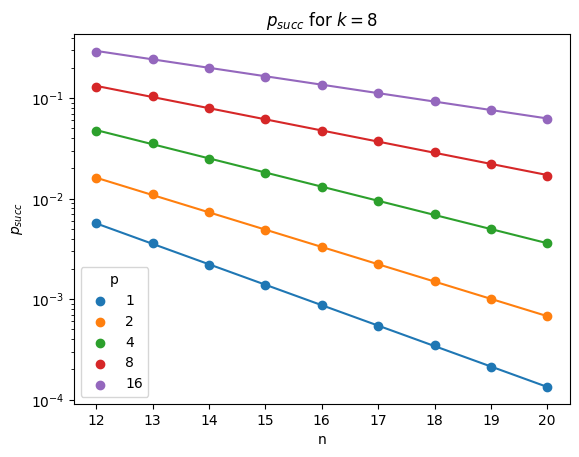

In [6]:
# Plot
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]

	for (p, psucc) in zip(ps, psucck):

		# Points
		ax.scatter(ns, psucc, label=p)

		# Line of best fit
		coefficients, error = np.polyfit(ns, np.log(psucc), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('$p_{succ}$')
	ax.legend(title='p')
	ax.set_title('$p_{succ}$'+ f' for $k = {k}$')

Next, we analyse and plot the median running times

In [7]:
# Extract
dir = f'{parent_dir}/experiments/ksat_eval/ksat_mrt'
rts = {k : {n : {p : torch.zeros(size=(num_proc * batch_size, )) for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			for p in ps:
				filename = f'{dir}/k_{k}/results/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					rts[k][n][p][index : index + batch_size] = fresh

mrts = {k : {n : {p : torch.median(rts[k][n][p]) for p in ps} for n in ns} for k in ks}

<Figure size 1500x1000 with 0 Axes>

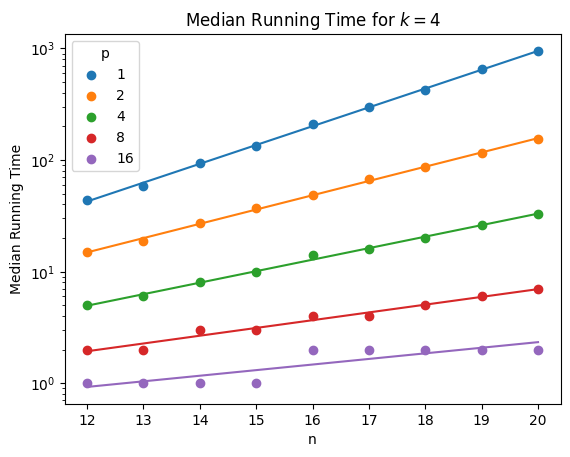

<Figure size 1500x1000 with 0 Axes>

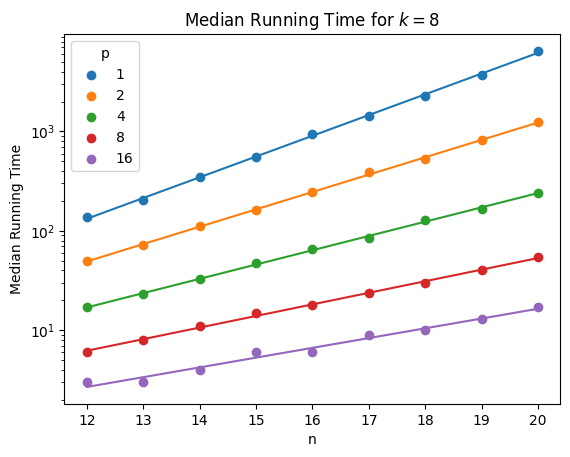

In [8]:
# Plot
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]

	for (p, mrt) in zip(ps, mrtk):

		# Points
		ax.scatter(ns, mrt, label=p)

		# Line of best fit
		coefficients, error = np.polyfit(ns, np.log(mrt), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

We evaluate the relationship

$$p_{succ} = \frac{1}{mrt}$$

<Figure size 1500x1000 with 0 Axes>

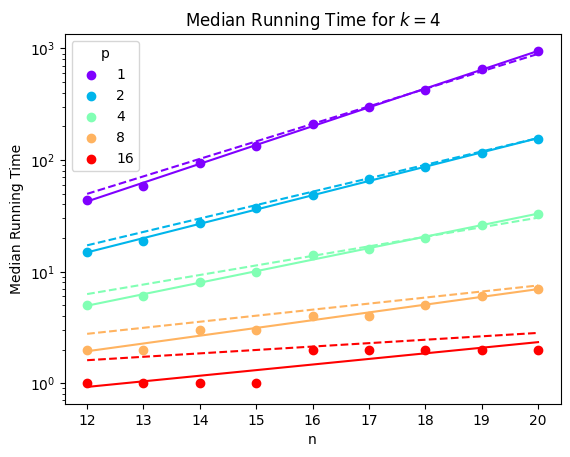

<Figure size 1500x1000 with 0 Axes>

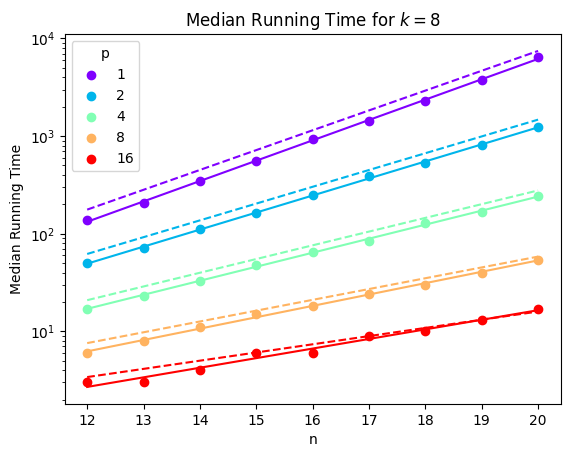

In [9]:
# Plot
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(ps))))

	for (p, mrtk, psucc) in zip(ps, mrtk, psucck):
		c = next(color)

		# mrt
		ax.scatter(ns, mrtk, label=p, color=c)
		coefficients, error = np.polyfit(ns, np.log(mrtk), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)), color=c)

		#psucc
		coefficients, error = np.polyfit(ns, np.log(psucc), 1, cov=True)
		polynomial = np.poly1d(-1 * coefficients)
		ax.plot(ns, np.exp(polynomial(ns)), color=c, linestyle='dashed')


	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

Coefficients:

In [11]:
psucc_coeffs = {k : {p : {} for p in ps} for k in ks}
mrt_coeffs = {k : {p : {} for p in ps} for k in ks}

for k in ks:
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
	for (p, mrtk, psucc) in zip(ps, mrtk, psucck):
		# mrt
		coefficients, error = np.polyfit(ns, np.log(mrtk), 1, cov=True)
		mrt_coeffs[k][p]['c'] = list(coefficients)
		mrt_coeffs[k][p]['r'] = list(error)
		#psucc
		coefficients, error = np.polyfit(ns, np.log(psucc), 1, cov=True)
		psucc_coeffs[k][p]['c'] = list(coefficients)
		psucc_coeffs[k][p]['r'] = list(error)

Next we consider the performance of WalkSAT